# Лабораторная работа №2

## Импортируем библиотеки

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np

import pandas as pd

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.feature_selection import mutual_info_classif, RFE, SelectKBest, chi2, SequentialFeatureSelector

from sklearn.linear_model import LogisticRegression, LinearRegression, LassoCV
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB


from sklearn.model_selection import train_test_split

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTETomek

from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt

from funcs import save_predicted, fit_classificator, test_by_cross_val, cross_fit_clf, get_probs_and_scores, make_mult_roc_curve_plots

import seaborn as sns

## Загрузим данные

In [2]:
sample_len = 20000
n_features_select = 5

df_train = pd.read_csv("Data/train.csv")

df_train = df_train.sample(n=sample_len, replace=False, random_state=42)
df_test = pd.read_csv("Data/test.csv")
df_test_res = df_test.copy()
df_train.head(10)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
46429,330050,Female,24,1,30.0,1,< 1 Year,No,24387.0,152.0,279,0
143349,97345,Female,70,1,28.0,1,1-2 Year,Yes,43438.0,26.0,222,0
196132,507223,Male,61,1,28.0,1,1-2 Year,No,55387.0,26.0,55,0
5066,492803,Female,24,1,4.0,1,< 1 Year,No,16569.0,152.0,40,0
211368,453644,Female,37,1,14.0,1,1-2 Year,No,35151.0,152.0,157,0
144277,182710,Male,28,1,4.0,1,< 1 Year,No,22933.0,152.0,126,0
102084,77128,Male,57,1,50.0,0,1-2 Year,Yes,46418.0,124.0,49,0
105877,419506,Male,45,1,8.0,0,1-2 Year,Yes,25689.0,4.0,188,1
175371,9734,Male,42,1,29.0,0,1-2 Year,Yes,2630.0,26.0,37,1
166965,14931,Female,30,1,28.0,0,1-2 Year,Yes,40628.0,124.0,248,0


###Определим тип столбцов

In [3]:
df_train.dtypes

id                        int64
Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

In [4]:
df_cat = ["Gender", "Vehicle_Age", "Vehicle_Damage"]
df_num = ["Age", "Driving_License", "Previously_Insured", "Region_Code", "Annual_Premium", "Policy_Sales_Channel", "Vintage"]
df_all = df_num + df_cat
result_col = "Response"
df_test_id_col = df_test["id"]

In [5]:
# df_pair = df_train.sample(n=500, replace=False, random_state=42)
#
# sns.pairplot(df_pair[df_all + [result_col]], hue=result_col, corner=True, markers=["o", "D"])
# plt.show()

In [6]:
print(f'Всего train записей: {len(df_train)}')
print(f'Всего в test записей: {len(df_test)}\n Null записи в train:')

df_train.isnull().sum()

Всего train записей: 20000
Всего в test записей: 152862
 Null записи в train:


id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

Так как все записи у нас хорошие (без пропусков) то оставляем их как есть. Так как объективно id не играет роли в предсказании - удалим его

In [7]:
df_train.drop("id", axis=1, inplace=True)

###кодируем категориальные признаки, затем нормализуем все признаки
Также создадим переменные для результата и признаков

In [8]:
le = LabelEncoder()
for col in df_cat:
    df_train[col] = le.fit_transform(df_train[col])
    df_test[col] = le.fit_transform(df_test[col])

scaler = MinMaxScaler()
df_train[df_all] = scaler.fit_transform(df_train[df_all])
df_test[df_all] = scaler.fit_transform(df_test[df_all])

x = df_train[df_all]
y = df_train[result_col]

## Отберем информативные признаки

Проверим существование линейной зависимости между признаками и результатом, выяснив их степень корреляции

<AxesSubplot: ylabel='Feature'>

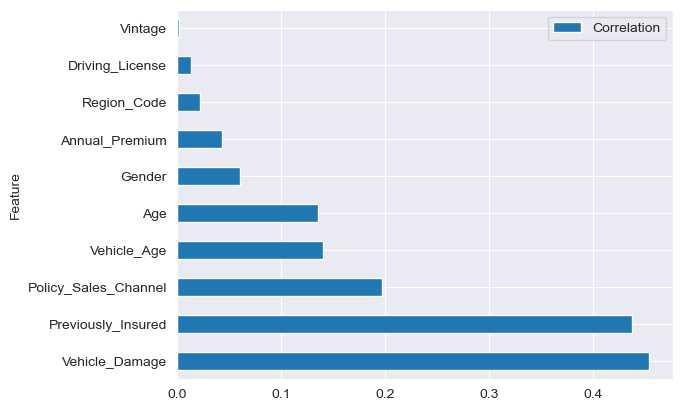

In [9]:
corr = df_train.corrwith(df_train[result_col])
corr_df = pd.DataFrame({"Feature": corr.index, "Correlation": abs(corr)})
corr_df.drop(corr_df.index[-1], inplace=True)
corr_df = corr_df.sort_values("Correlation", ascending=False)
corr_df.plot(kind="barh", x="Feature", y="Correlation")

Так как нет значений близких к единице, линейной зависимости не наблюдается

### Метод фильтрации
Используем Mutual information, так как зависимости нелинейные

In [10]:
selector = SelectKBest(chi2, k=n_features_select)
selector.fit_transform(x, y)
selected_features_chi2 = selector.get_feature_names_out()

### Метод обертки
Используем SequentialFeatureSelector

In [11]:
sfs = SequentialFeatureSelector(LinearDiscriminantAnalysis(), n_features_to_select=n_features_select)
top_five = sfs.fit(x, y)
selected_features_SFS = top_five.get_feature_names_out()

### Встроенный метод

In [12]:
rfe = RFE(LinearDiscriminantAnalysis(), n_features_to_select=n_features_select)
top_five = rfe.fit(x, y)
selected_built_in = top_five.get_feature_names_out()

In [13]:
selected_dict = {
    "Фильтрация": selected_features_chi2,
    "Обертка": selected_features_SFS,
    "Встроенные": selected_built_in,
    "Без фльтрации": df_all
}

### Сравним результаты отбора

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=7)

scores = []
for selector_name, selected in selected_dict.items():
    x_train_sel = x_train.loc[:, selected]
    x_test_sel = x_test.loc[:, selected]

    score = test_by_cross_val(LinearDiscriminantAnalysis(), x_train_sel, y_train, x_test_sel, y_test)

    scores.append((selector_name, score))

### Покажем графически результаты анализа

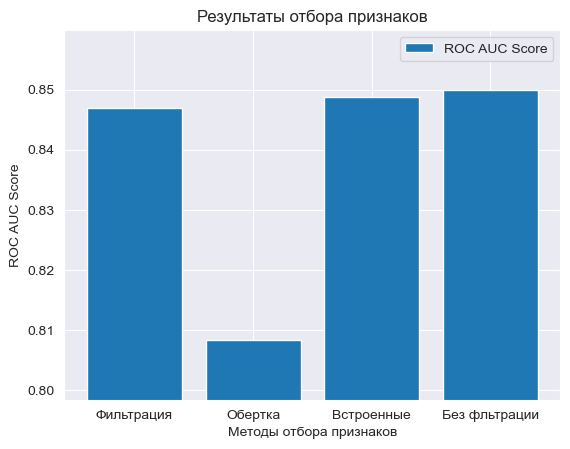

In [15]:
methods = [sc[0] for sc in scores]
roc_scores = [sc[1] for sc in scores]

fig, ax = plt.subplots()

plt.bar(methods, roc_scores, label='ROC AUC Score')

plt.gca().set_xlabel('Методы отбора признаков')
plt.gca().set_ylabel('ROC AUC Score')
plt.gca().set_title('Результаты отбора признаков')
plt.gca().legend()
plt.gca().set_ylim([min(roc_scores) - 0.01, max(roc_scores) + 0.01])

plt.show()

### Используем лучший вариант

In [16]:
best = max(scores, key=lambda sc: sc[1])[0]
print("Лучший метод:", best)
selected_features = selected_dict[best]

df_train = df_train.loc[:, np.append(selected_features, result_col)]
df_test = df_test.loc[:, selected_features]

# df_test = df_test.loc[:, df_all]
df_all = selected_features

x = df_train[df_all]
y = df_train[result_col]

Лучший метод: Без фльтрации


##Сэмплирование

Выясним различия значений Response

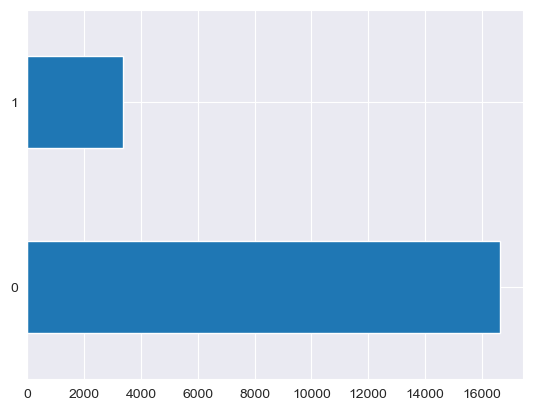

In [17]:
y.value_counts().plot(kind="barh")
plt.show()

### Применим различные виды ресемплинга

In [18]:
ros_xy = RandomOverSampler(random_state=7).fit_resample(x, y)

rus_xy = RandomUnderSampler(random_state=7).fit_resample(x, y)

smote_xy = SMOTE(random_state=7).fit_resample(x, y)

# tl_xy = TomekLinks().fit_resample(x, y)

smote_t_xy = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'), random_state=7).fit_resample(x, y)


### Сравним полученные результаты

In [19]:
resampled_dict = {
    "oversampling": ros_xy,
    "oversampling SMOTE": smote_xy,
    "undersampling": rus_xy,
    "SMOTETomek": smote_t_xy,
    "non resampled": (x, y)
}

In [20]:
scores = []

for sampler, sample in resampled_dict.items():
    x_train, x_test, y_train, y_test = train_test_split(*sample, test_size=0.3, random_state=7)
    scores.append((sampler, test_by_cross_val(GaussianNB(), x_train, y_train, x_test, y_test)))

### Сравним графически результаты ресемплинга

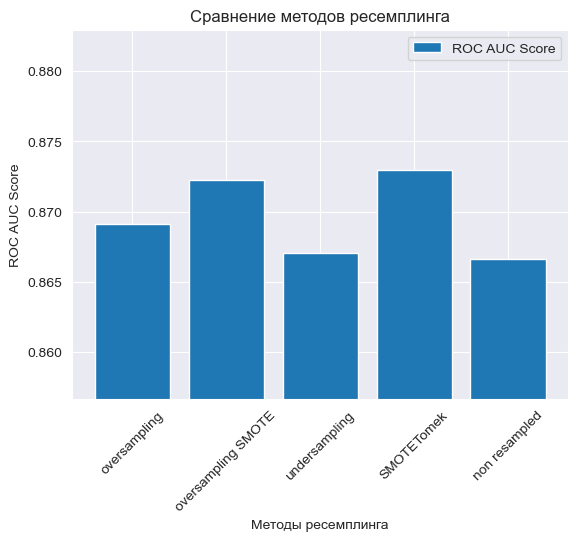

In [21]:
methods = [sc[0] for sc in scores]
roc_scores = [sc[1] for sc in scores]

plt.bar(methods, roc_scores, label='ROC AUC Score')
plt.xticks(rotation=45)
plt.gca().set_xlabel('Методы ресемплинга')
plt.gca().set_ylabel('ROC AUC Score')
plt.gca().set_title('Сравнение методов ресемплинга')
plt.gca().legend()
plt.gca().set_ylim([min(roc_scores) - 0.01, max(roc_scores) + 0.01])

plt.show()

### Получим выборку из лучшего ресемплера

In [22]:
best = max(scores, key=lambda sx: sx[1])[0]
print(f"Лучший ресемплер: {best}")
x, y = resampled_dict[best]


Лучший ресемплер: SMOTETomek


### Посмотрим различия значений Response

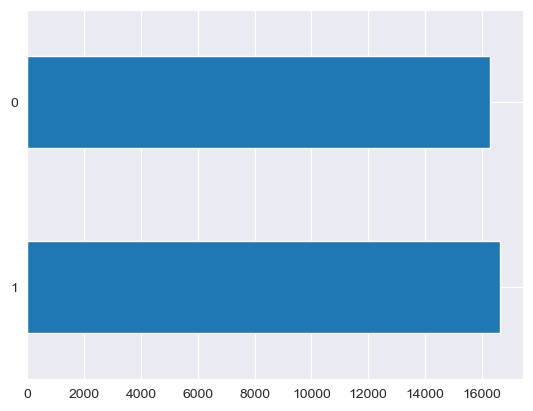

In [23]:
y.value_counts().plot(kind="barh")
plt.show()

Разобьем исходные данные на две подвыборки

In [24]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=7)
all_data = (x_train, y_train, x_test, y_test)

##Подбор моделей классификаторов

In [25]:
all_classifs = []
all_classifs_names = []
scores_to_csv = {}

### Метод KNN

In [26]:
params = {'n_neighbors': range(15, 20),
          'weights': ['uniform', 'distance']}
resp = fit_classificator(KNeighborsClassifier, params, *all_data)
knn = resp["model"]

all_classifs.append(knn)
all_classifs_names.append("knn")

print('Лучшие параметры:', resp["best_params"])
print('ROC-AUC:', resp["score"])
scores_to_csv[all_classifs_names[-1]] = resp["score"]

Лучшие параметры: {'n_neighbors': 15, 'weights': 'distance'}
ROC-AUC: 0.939


### Логистическая регрессия

In [27]:
params = {'penalty':['l1', 'l2', 'elasticnet'], 'C':[0.001, 0.01, 0.1, 1, 10, 100]}

resp = fit_classificator(LogisticRegression, params, *all_data)
log_reg = resp["model"]

all_classifs.append(log_reg)
all_classifs_names.append("log_reg")

print('Лучшие параметры:', resp["best_params"])
print('ROC-AUC:', resp["score"])
scores_to_csv[all_classifs_names[-1]] = resp["score"]


Лучшие параметры: {'C': 0.1, 'penalty': 'l2'}
ROC-AUC: 0.857


### Наивный байесовский классификатор

In [28]:
gauss_nb = cross_fit_clf(GaussianNB(), x_train, y_train)

test_score = get_probs_and_scores(gauss_nb, x_train, y_train, x_test, y_test)["test_score"]

all_classifs.append(gauss_nb)
all_classifs_names.append("gauss_nb")

print('ROC-AUC:', test_score)
scores_to_csv[all_classifs_names[-1]] = test_score


ROC-AUC: 0.8729607018637147


### Метод опорных векторов

In [29]:
svc = SVC(probability=True)
svc.fit(x_train, y_train)

test_score = get_probs_and_scores(svc, x_train, y_train, x_test, y_test)["test_score"]

all_classifs.append(svc)
all_classifs_names.append("svc")

print('ROC-AUC:', test_score)
scores_to_csv[all_classifs_names[-1]] = test_score


ROC-AUC: 0.8871510317521701


### Линейный дискриминантный анализ

In [30]:
lda = cross_fit_clf(LinearDiscriminantAnalysis(), x_train, y_train)

test_score = get_probs_and_scores(lda, x_train, y_train, x_test, y_test)["test_score"]

all_classifs.append(lda)
all_classifs_names.append("lda")

print('ROC-AUC:', test_score)
scores_to_csv[all_classifs_names[-1]] = test_score


ROC-AUC: 0.8571347240480452


### Квадратичный дискриминантный анализ

In [31]:
qda = cross_fit_clf(QuadraticDiscriminantAnalysis(), x_train, y_train)

test_score = get_probs_and_scores(qda, x_train, y_train, x_test, y_test)["test_score"]

all_classifs.append(qda)
all_classifs_names.append("qda")

print('ROC-AUC:', test_score)
scores_to_csv[all_classifs_names[-1]] = test_score


ROC-AUC: 0.8801001538220596


In [32]:
pd.Series(scores_to_csv).to_csv("scores2.csv")

## Вывод графиков ROC кривой

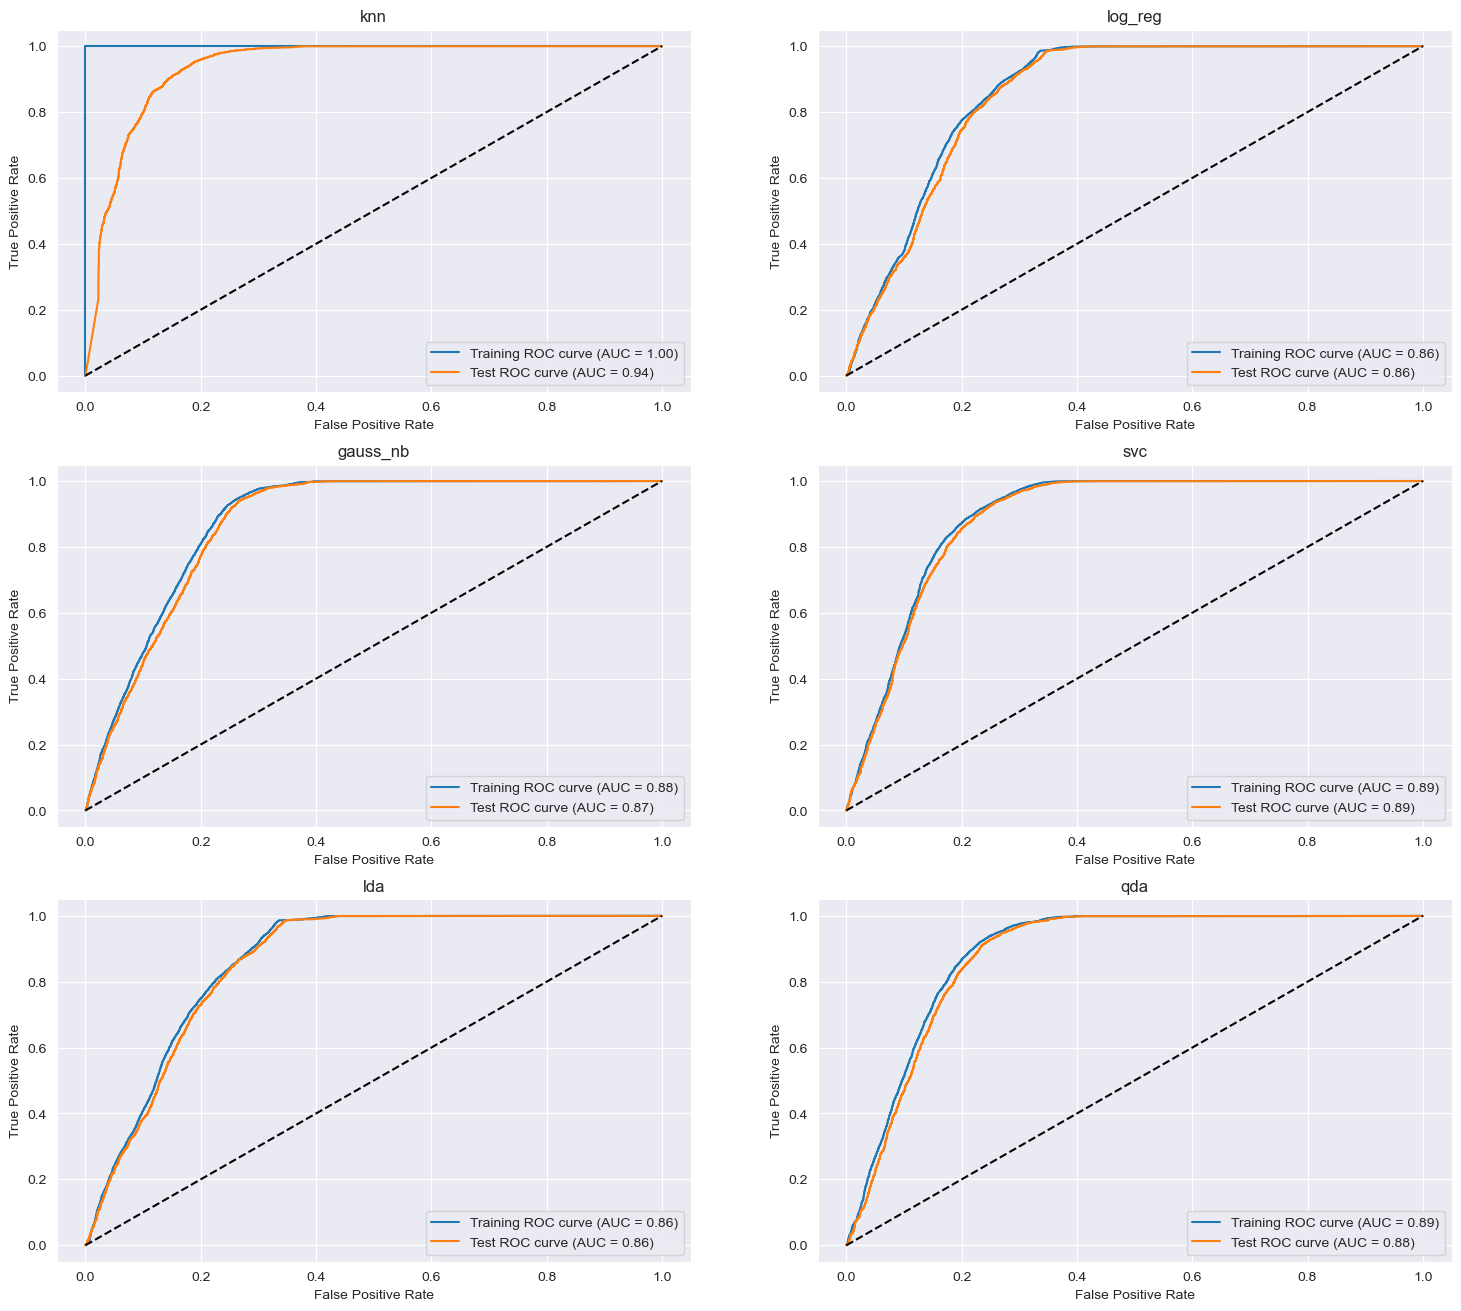

In [32]:
make_mult_roc_curve_plots(zip(all_classifs, all_classifs_names), *all_data)

## Сохранение результатов

In [33]:
for classif, name in zip(all_classifs, all_classifs_names):
    save_predicted(df_test_id_col, classif.predict(df_test), name)

## Сохранение результатов

In [34]:
for classif, name in zip(all_classifs, all_classifs_names):
    save_predicted(df_test_id_col, classif, name)